### Introduction

The objective of this Colab notebook is to explore a hypothesis I have developed during my tenure in capital markets. It stems from the observation that, while gold stocks tend to move in concert with each other, their movements are not perfectly synchronized. My hypothesis posits that by examining the degree and direction of deviation of individual equities from the mean, as a function of a variable—in this case, the gold price—we can infer the market's relative valuation of an equity.

In other words, by analyzing gold producers and gold royalty/streaming companies with a substantial portion of their revenue derived from gold, we can observe how their daily returns correlate with changes in the gold price. I believe that the more undervalued a company is, the higher its returns will be on days when the gold price significantly increases. Conversely, the decline in share price will be less pronounced on days when the gold price decreases. I am fundamentally seeking to quantify market inefficiency by assessing the magnitude of what I interpret as corrective movements.

We can quantify this relationship with a ratio, termed the "SensitivityRatio," which is calculated using the least squared slope of daily changes under positive and negative gold price fluctuations:

$$
SensitivityRatio = \frac{(daily change_{Auprice+})}{(daily change_{Auprice-})}
$$


In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import linregress

# Set matplotlib style
plt.style.use('ggplot')

# Set seaborn style
sns.set(style="whitegrid")

# Set plotting defaults
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


**Define the company tickers and download data**

Here we will look at one year, and will use company's of various sizes. We will separate it into three tiers of gold producers, and also take the three largest global royalty/streamers.

In [12]:
# Define the tickers for each category
senior_producers = ["NEM", "GOLD", "AEM"]
intermediate_producers = ["EDV.TO", "PAAS", "BTO.TO", "KGC"]
junior_producers = ["AGI", "ELD.TO", "SSRM"]
royalty_streaming = ["FNV", "WPM", "RGLD"]

# Combine all tickers into one list
all_tickers = ["GC=F"] + senior_producers + intermediate_producers + junior_producers + royalty_streaming

# Download the data
data = yf.download(all_tickers, start="2023-01-01", end="2024-01-01")

# Display the first few rows of the data
data.head()


[*********************100%%**********************]  14 of 14 completed


Price       Adj Close                                                     \
Ticker            AEM        AGI    BTO.TO     EDV.TO ELD.TO         FNV   
Date                                                                       
2023-01-03  51.119324  10.256824  4.727335  27.596046  11.62  136.285431   
2023-01-04  52.951832  10.741945  4.896505  28.327936  11.96  140.053879   
2023-01-05  52.045124  10.672641  4.915301  28.468685  11.78  137.962494   
2023-01-06  52.760944  10.751845  4.934098  29.172426  11.99  137.913193   
2023-01-09  52.216927  10.583538  4.821319  29.041061  11.69  140.182129   

Price                                                    ...    Volume  \
Ticker             GC=F       GOLD       KGC        NEM  ...    ELD.TO   
Date                                                     ...             
2023-01-03  1839.699951  17.185104  4.121202  46.996658  ...  449700.0   
2023-01-04  1852.800049  18.197124  4.372142  48.826099  ...  494400.0   
2023-01-05  1834.800049  18.100746  4.285278  48.541729  ...  514600.0   
2023-01-06  1864.199951  18.351343  4.410748  49.944614  ...  488600.0   
2023-01-09  1872.699951  18.283869  4.362491  49.499104  ...  344900.0   

Price                                                                      \
Ticker           FNV  GC=F        GOLD         KGC         NEM       PAAS   
Date                                                                        
2023-01-03  635100.0  29.0  16347400.0  16253200.0   8431400.0  5326800.0   
2023-01-04  626700.0  25.0  29096000.0  27465900.0  11532000.0  5695200.0   
2023-01-05  425000.0  24.0  17933600.0  17782200.0   7037000.0  4532600.0   
2023-01-06  991400.0  26.0  21704000.0  19802600.0   7424900.0  4087200.0   
2023-01-09  953900.0  62.0  18346700.0  13361500.0   7561800.0  3030600.0   

Price                                       
Ticker          RGLD       SSRM        WPM  
Date                                        
2023-01-03  584500.0  1155700.0  2179400.0  
2023-01-04  682100.0  2033900.0  3884000.0  
2023-01-05  358200.0  1585000.0  2274000.0  
2023-01-06  623800.0  1204500.0  3608500.0  
2023-01-09  543100.0  1112900.0  2302900.0  

[5 rows x 84 columns]

In [13]:
# Focus on the 'Adj Close' prices
adj_close = data['Adj Close']

# Handle missing values by forward filling
adj_close.ffill(inplace=True)

# Display the first few rows of the adjusted close prices
adj_close.head()


Ticker,AEM,AGI,BTO.TO,EDV.TO,ELD.TO,FNV,GC=F,GOLD,KGC,NEM,PAAS,RGLD,SSRM,WPM
Date,,,,,,,,,,,,,,
2023-01-03,51.119324,10.256824,4.727335,27.596046,11.62,136.285431,1839.699951,17.185104,4.121202,46.996658,16.526155,114.575638,15.888876,39.808308
2023-01-04,52.951832,10.741945,4.896505,28.327936,11.96,140.053879,1852.800049,18.197124,4.372142,48.826099,17.219156,116.919533,16.545605,41.162399
2023-01-05,52.045124,10.672641,4.915301,28.468685,11.78,137.962494,1834.800049,18.100746,4.285278,48.541729,16.757156,118.577225,16.388775,41.182026
2023-01-06,52.760944,10.751845,4.934098,29.172426,11.99,137.913193,1864.199951,18.351343,4.410748,49.944614,17.074781,122.768211,16.888670,42.487049
2023-01-09,52.216927,10.583538,4.821319,29.041061,11.69,140.182129,1872.699951,18.283869,4.362491,49.499104,16.930407,120.426773,16.486792,42.074936


In [14]:
# Calculate daily returns
daily_returns = adj_close.pct_change().dropna()

# Display the first few rows of daily returns
daily_returns.head()


Ticker,AEM,AGI,BTO.TO,EDV.TO,ELD.TO,FNV,GC=F,GOLD,KGC,NEM,PAAS,RGLD,SSRM,WPM
Date,,,,,,,,,,,,,,
2023-01-04,0.035848,0.047297,0.035785,0.026522,0.029260,0.027651,0.007121,0.058889,0.060890,0.038927,0.041934,0.020457,0.041333,0.034015
2023-01-05,-0.017123,-0.006452,0.003839,0.004969,-0.015050,-0.014933,-0.009715,-0.005296,-0.019868,-0.005824,-0.026831,0.014178,-0.009479,0.000477
2023-01-06,0.013754,0.007421,0.003824,0.024720,0.017827,-0.000357,0.016023,0.013845,0.029279,0.028901,0.018955,0.035344,0.030502,0.031689
2023-01-09,-0.010311,-0.015654,-0.022857,-0.004503,-0.025021,0.016452,0.004560,-0.003677,-0.010941,-0.008920,-0.008455,-0.019072,-0.023796,-0.009700
2023-01-10,0.009687,0.018709,0.031189,0.026494,0.033362,0.014075,-0.000587,0.022140,0.019911,0.017809,0.028425,0.018953,0.013674,0.013526


In [15]:
# Calculate the correlation matrix
correlation_matrix = daily_returns.corr()

# Display the correlation matrix
correlation_matrix


Ticker,AEM,AGI,BTO.TO,EDV.TO,ELD.TO,FNV,GC=F,GOLD,KGC,NEM,PAAS,RGLD,SSRM,WPM
Ticker,,,,,,,,,,,,,,
AEM,1.000000,0.827003,0.758722,0.723794,0.684292,0.766515,0.688686,0.886755,0.844806,0.786810,0.803141,0.821012,0.683434,0.842734
AGI,0.827003,1.000000,0.731532,0.711901,0.678141,0.724544,0.626007,0.785252,0.815336,0.682872,0.785100,0.787273,0.648213,0.798634
BTO.TO,0.758722,0.731532,1.000000,0.680990,0.687056,0.634236,0.591966,0.738283,0.706691,0.668778,0.679826,0.676227,0.617315,0.669581
EDV.TO,0.723794,0.711901,0.680990,1.000000,0.568513,0.603968,0.622746,0.699011,0.719877,0.608424,0.690426,0.713862,0.582550,0.703600
ELD.TO,0.684292,0.678141,0.687056,0.568513,1.000000,0.571858,0.507204,0.644580,0.633467,0.563846,0.627920,0.612730,0.560665,0.636013
FNV,0.766515,0.724544,0.634236,0.603968,0.571858,1.000000,0.539647,0.706694,0.714501,0.655658,0.692898,0.704970,0.609657,0.740619
GC=F,0.688686,0.626007,0.591966,0.622746,0.507204,0.539647,1.000000,0.686540,0.662296,0.611158,0.675092,0.627677,0.550755,0.670637
GOLD,0.886755,0.785252,0.738283,0.699011,0.644580,0.706694,0.686540,1.000000,0.825908,0.803686,0.801076,0.823037,0.653396,0.826523
KGC,0.844806,0.815336,0.706691,0.719877,0.633467,0.714501,0.662296,0.825908,1.000000,0.713490,0.769642,0.771697,0.625487,0.839533


**Correlation Analysis**

The following heatmap presents the correlation matrix for a selection of gold producers, gold royalty/streaming companies, and the gold price itself (represented by GC=F).

The matrix displays Pearson correlation coefficients, which measure the linear relationship between pairs of variables. A coefficient close to 1 indicates a strong positive correlation, implying that the stocks or the gold price tend to move in the same direction. Conversely, a coefficient close to -1 indicates a strong negative correlation, while a coefficient around 0 suggests no linear relationship.

Key observations from the matrix include:

* High Correlation Among Gold Producers: Companies like AEM, AGI, and KGC show strong correlations (above 0.8) with each other, indicating that these stocks tend to move together, likely due to similar market influences and exposure to gold prices.
* Gold Price Correlation: The correlation coefficients between gold stocks and the gold price (GC=F) generally range from 0.5 to 0.7, suggesting a moderate to strong relationship. This aligns with expectations, as the revenue and profitability of these companies are closely tied to gold prices.
* Distinct Correlations with Streaming Companies: Royalty and streaming companies like FNV and WPM also show substantial correlations with gold prices and other stocks, though slightly lower than pure gold producers. This may reflect their unique business models and diversified revenue streams.

Overall, this correlation analysis highlights the interconnected nature of the gold market and its equities, providing valuable insights for portfolio management and investment strategies.

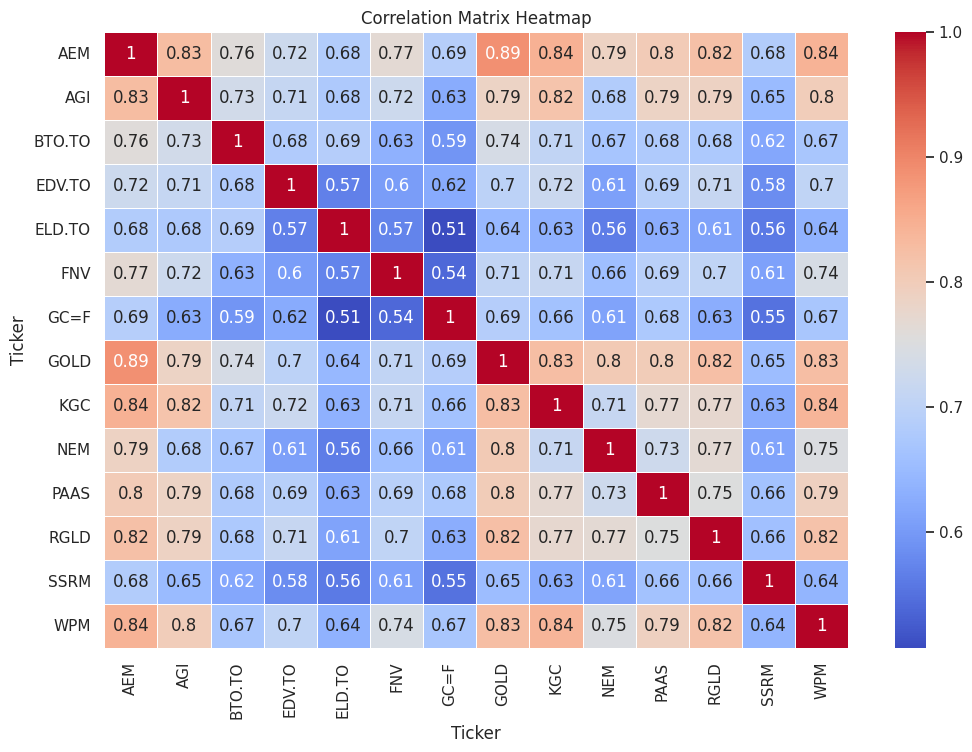

In [16]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


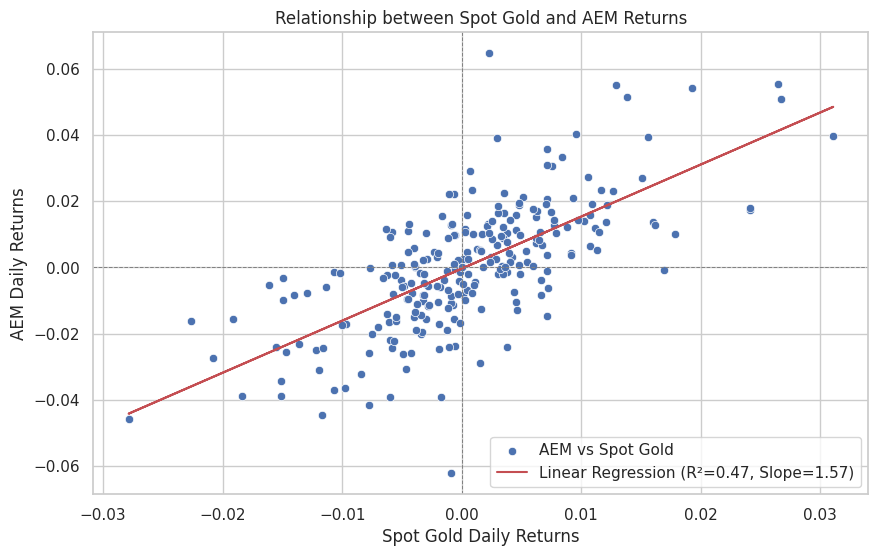

AEM vs Spot Gold:
  R-squared: 0.47
  Slope: 1.57



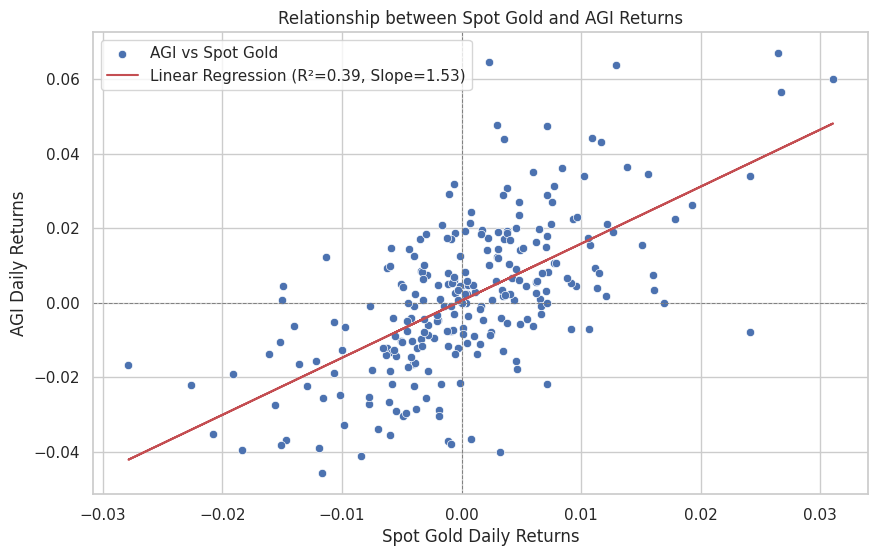

AGI vs Spot Gold:
  R-squared: 0.39
  Slope: 1.53



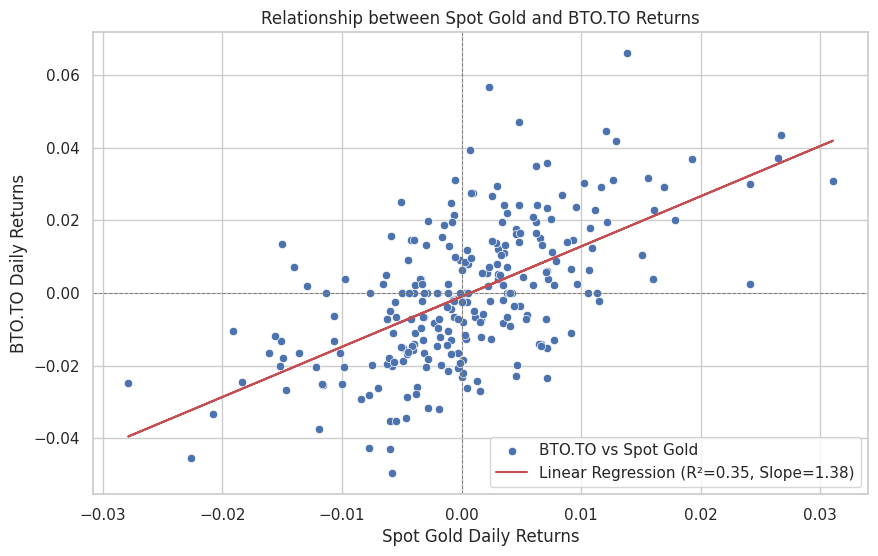

BTO.TO vs Spot Gold:
  R-squared: 0.35
  Slope: 1.38



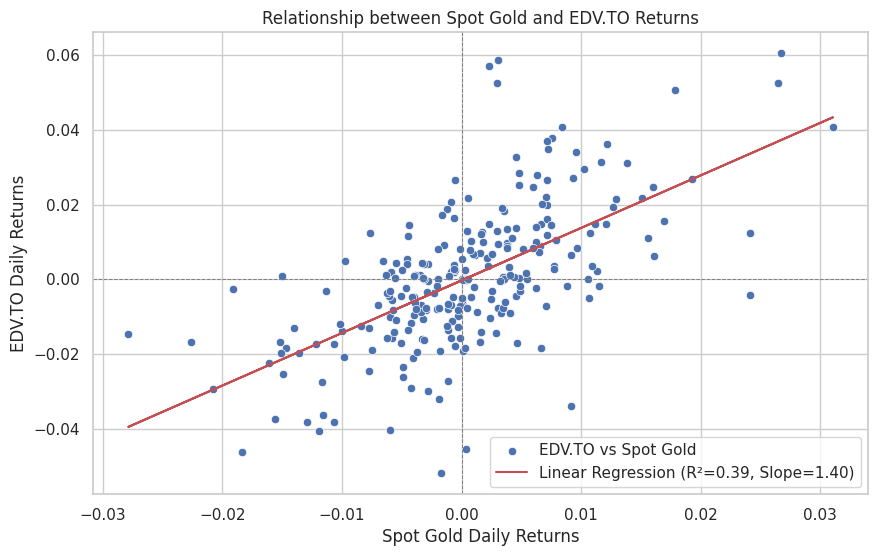

EDV.TO vs Spot Gold:
  R-squared: 0.39
  Slope: 1.40



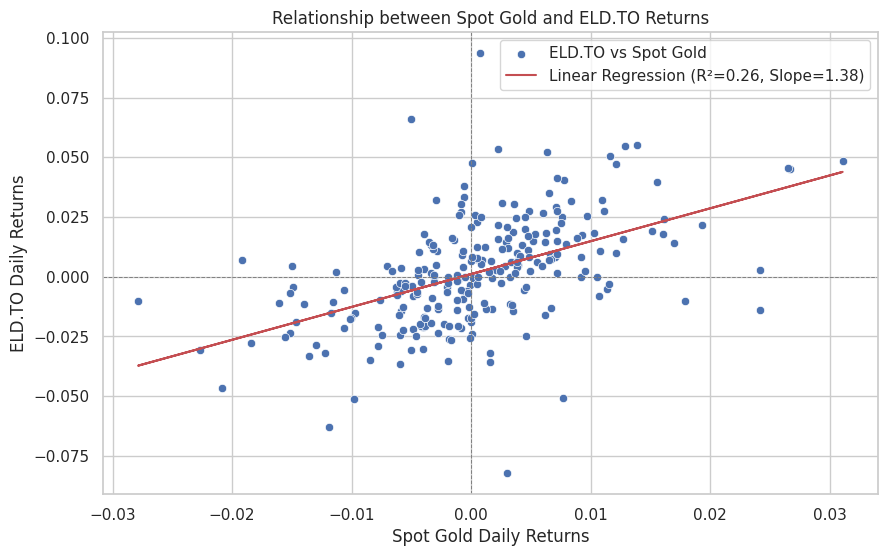

ELD.TO vs Spot Gold:
  R-squared: 0.26
  Slope: 1.38



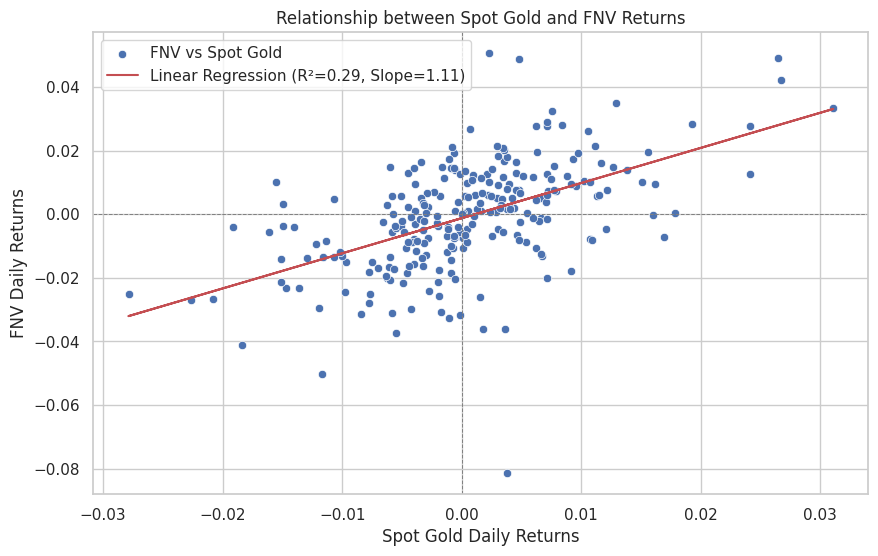

FNV vs Spot Gold:
  R-squared: 0.29
  Slope: 1.11



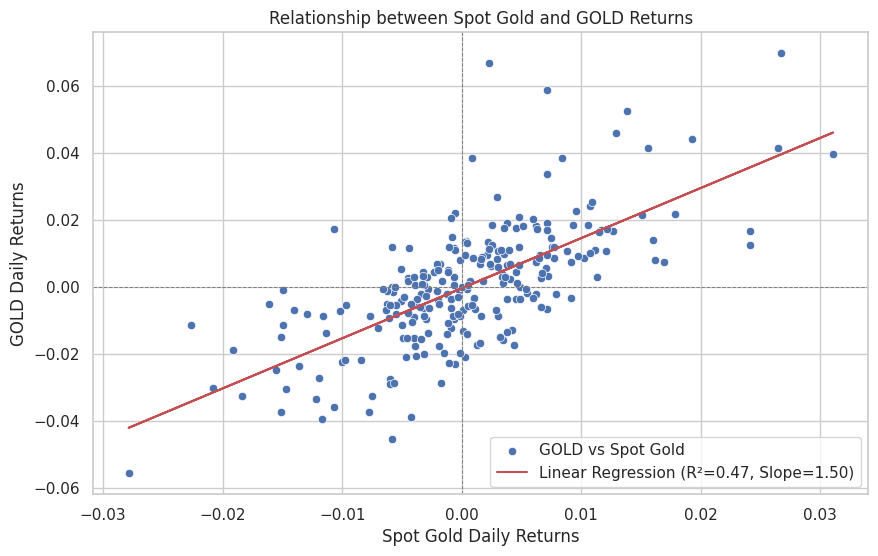

GOLD vs Spot Gold:
  R-squared: 0.47
  Slope: 1.50



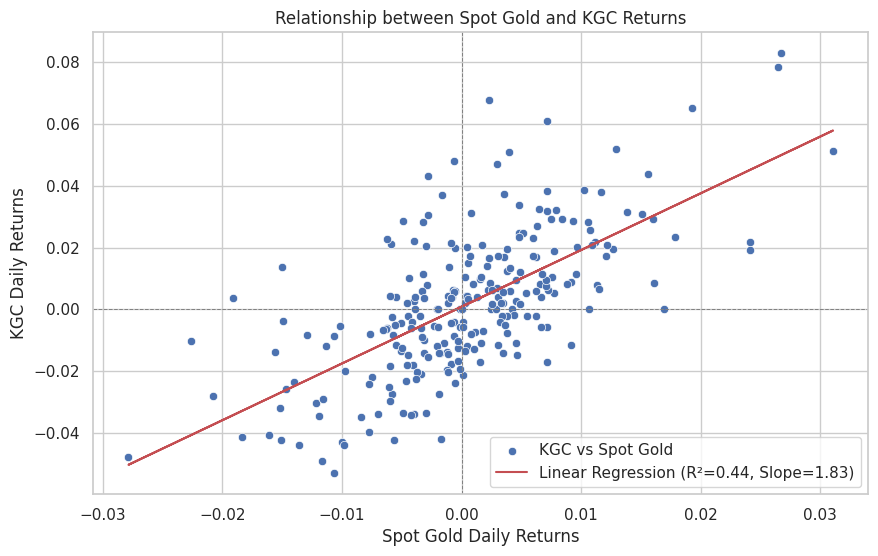

KGC vs Spot Gold:
  R-squared: 0.44
  Slope: 1.83



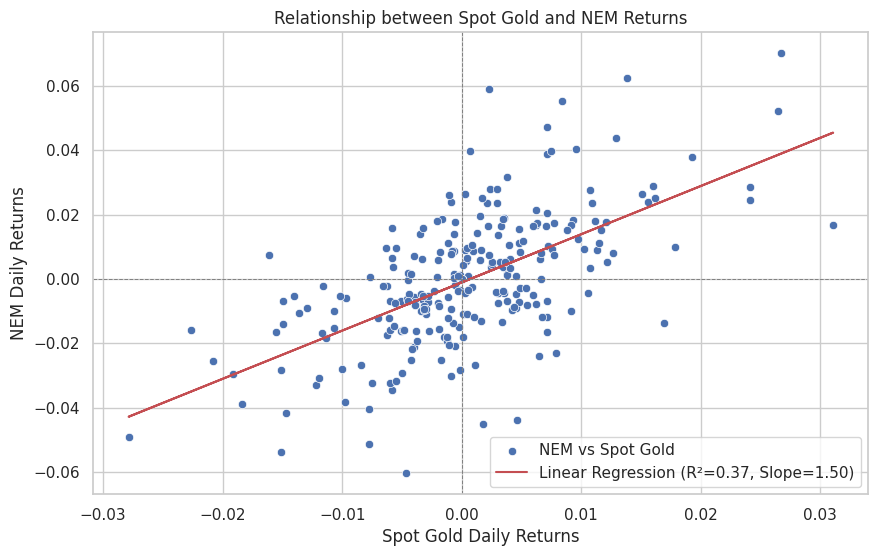

NEM vs Spot Gold:
  R-squared: 0.37
  Slope: 1.50



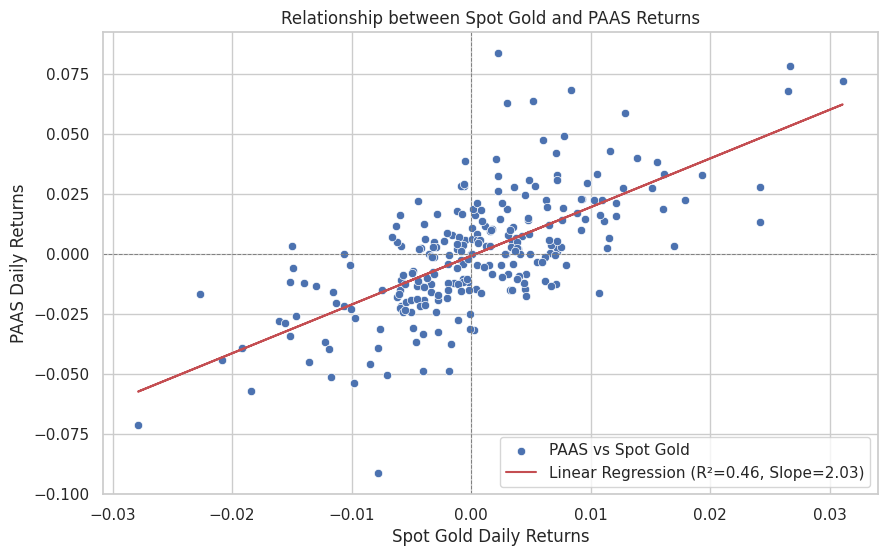

PAAS vs Spot Gold:
  R-squared: 0.46
  Slope: 2.03



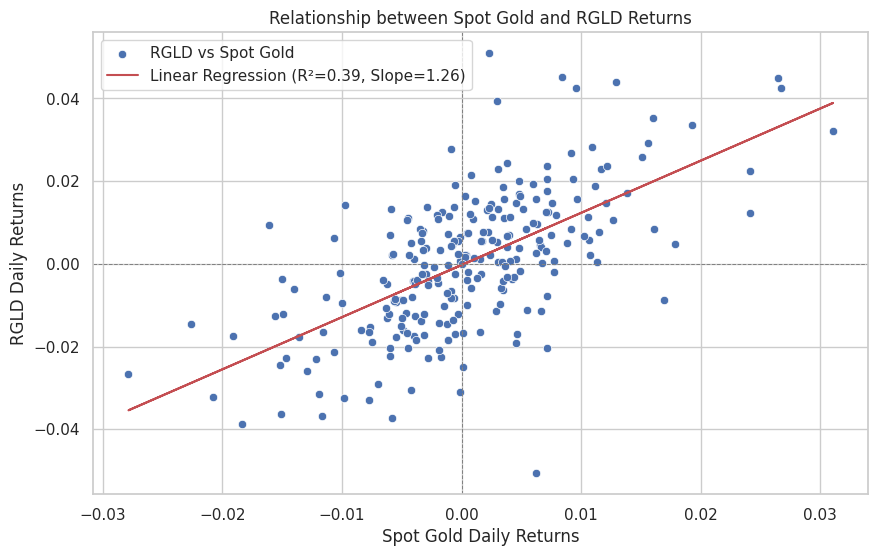

RGLD vs Spot Gold:
  R-squared: 0.39
  Slope: 1.26



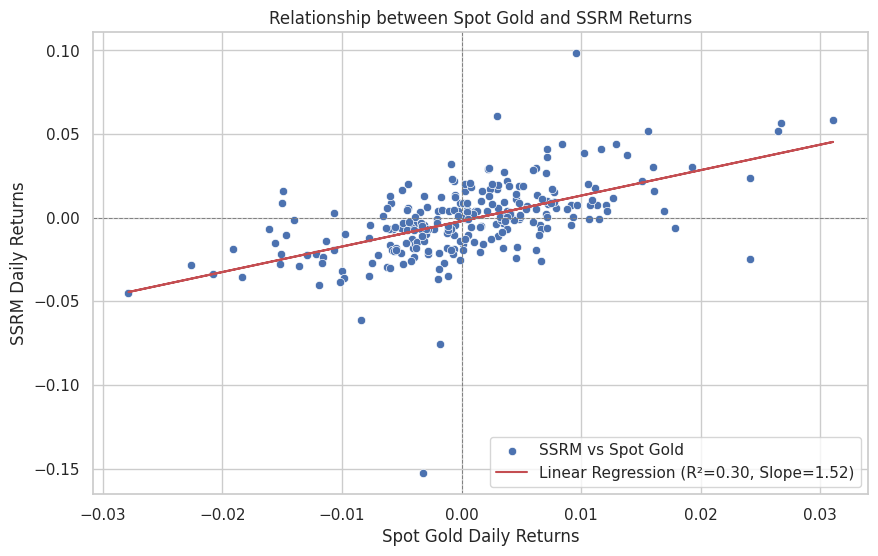

SSRM vs Spot Gold:
  R-squared: 0.30
  Slope: 1.52



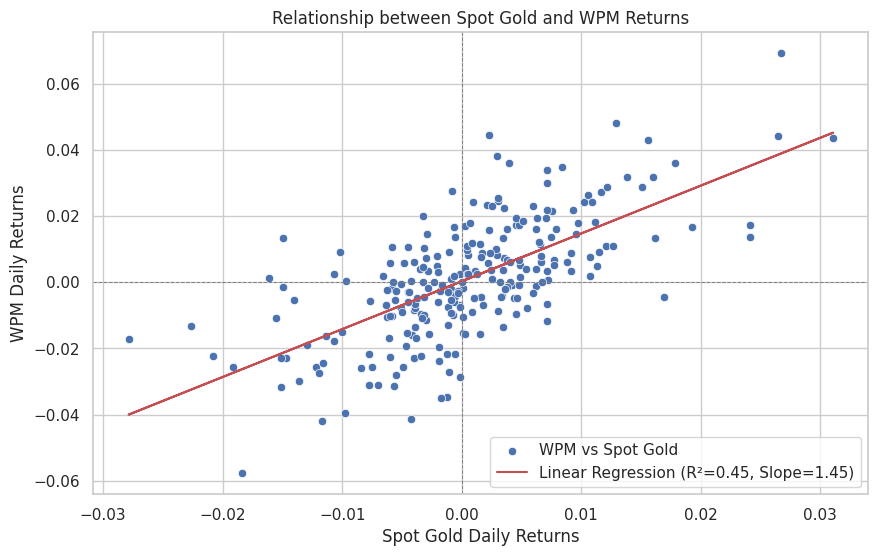

WPM vs Spot Gold:
  R-squared: 0.45
  Slope: 1.45



In [17]:
# Plot daily returns of spot gold against daily returns of each individual stock
spot_gold_returns = daily_returns["GC=F"]

# List of all companies excluding spot gold
companies = daily_returns.columns.drop("GC=F")

# Plot scatter plots with linear regression
for company in companies:
    plt.figure(figsize=(10, 6))

    # Scatter plot
    sns.scatterplot(x=spot_gold_returns, y=daily_returns[company], label=f'{company} vs Spot Gold')

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(spot_gold_returns, daily_returns[company])

    # Plot regression line
    plt.plot(spot_gold_returns, intercept + slope * spot_gold_returns, 'r', label=f'Linear Regression (R²={r_value**2:.2f}, Slope={slope:.2f})')

    # Plot titles and labels
    plt.title(f'Relationship between Spot Gold and {company} Returns')
    plt.xlabel('Spot Gold Daily Returns')
    plt.ylabel(f'{company} Daily Returns')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.legend()

    # Show plot
    plt.show()

    # Print R-squared and slope
    print(f'{company} vs Spot Gold:')
    print(f'  R-squared: {r_value**2:.2f}')
    print(f'  Slope: {slope:.2f}\n')

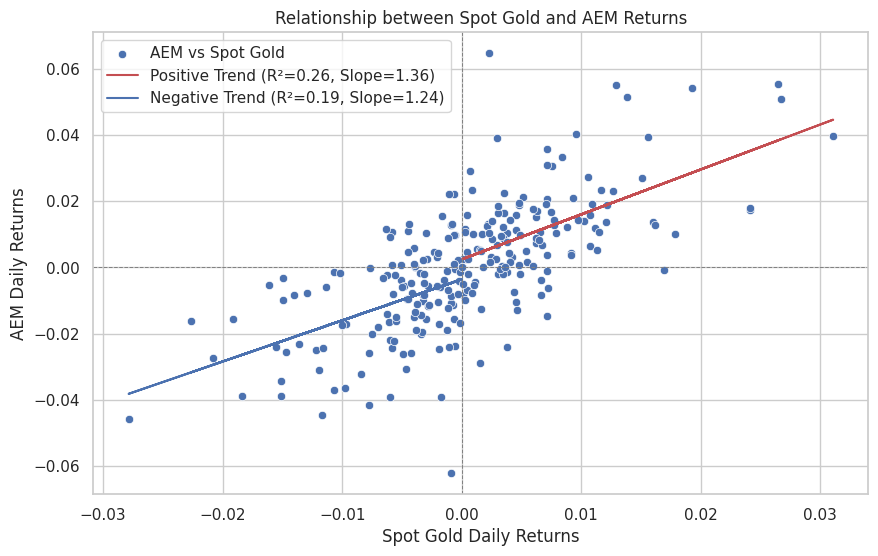

AEM vs Spot Gold (Positive Changes):
  R-squared: 0.26
  Slope: 1.36

AEM vs Spot Gold (Negative Changes):
  R-squared: 0.19
  Slope: 1.24

AEM Slope Ratio (Positive/Negative): 1.09



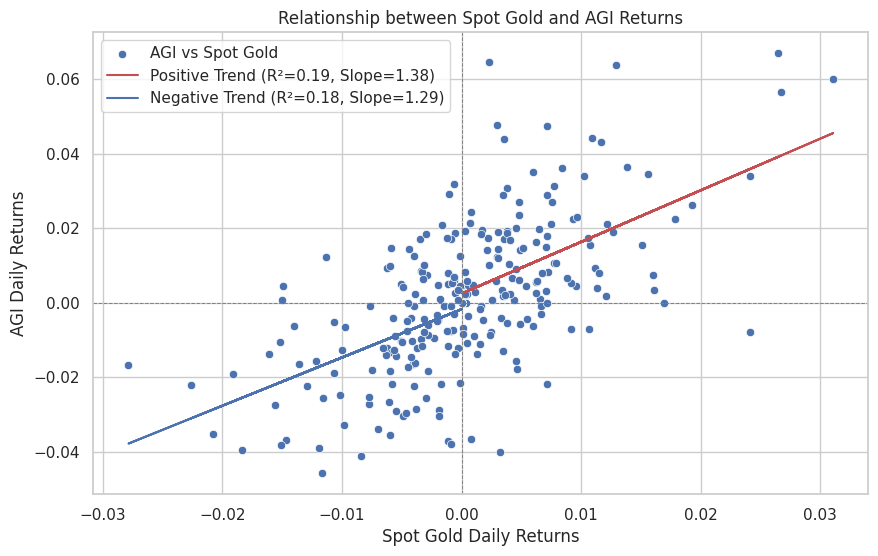

AGI vs Spot Gold (Positive Changes):
  R-squared: 0.19
  Slope: 1.38

AGI vs Spot Gold (Negative Changes):
  R-squared: 0.18
  Slope: 1.29

AGI Slope Ratio (Positive/Negative): 1.07



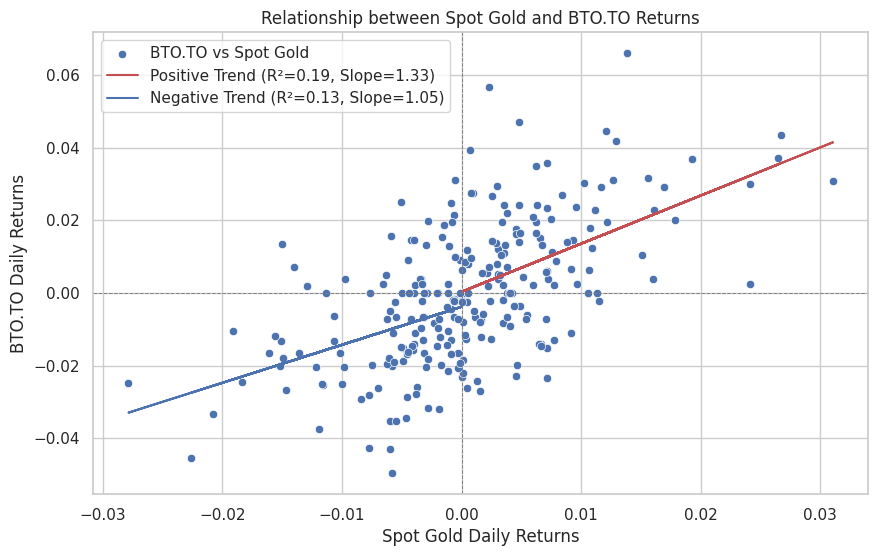

BTO.TO vs Spot Gold (Positive Changes):
  R-squared: 0.19
  Slope: 1.33

BTO.TO vs Spot Gold (Negative Changes):
  R-squared: 0.13
  Slope: 1.05

BTO.TO Slope Ratio (Positive/Negative): 1.27



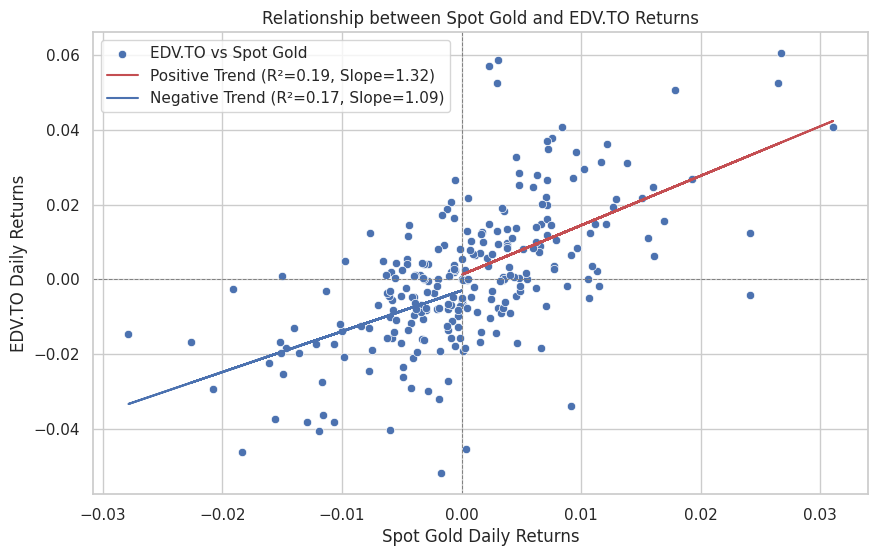

EDV.TO vs Spot Gold (Positive Changes):
  R-squared: 0.19
  Slope: 1.32

EDV.TO vs Spot Gold (Negative Changes):
  R-squared: 0.17
  Slope: 1.09

EDV.TO Slope Ratio (Positive/Negative): 1.22



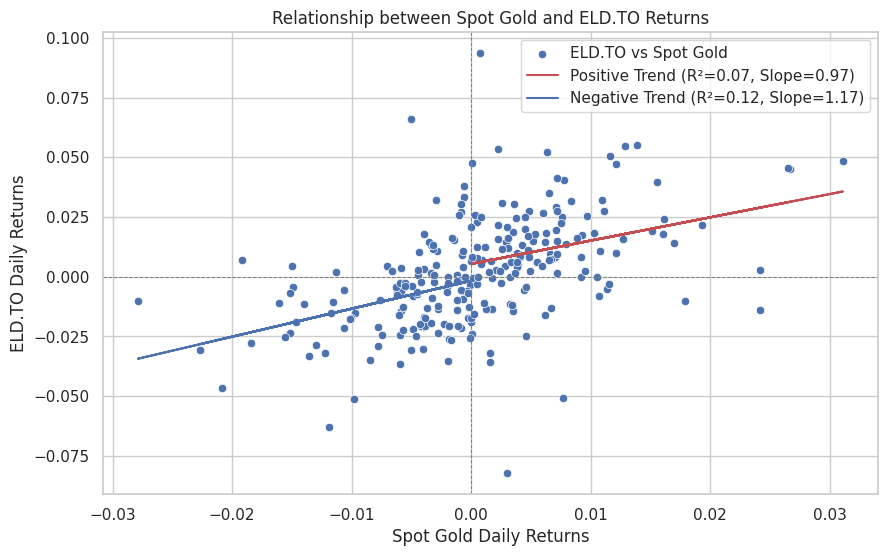

ELD.TO vs Spot Gold (Positive Changes):
  R-squared: 0.07
  Slope: 0.97

ELD.TO vs Spot Gold (Negative Changes):
  R-squared: 0.12
  Slope: 1.17

ELD.TO Slope Ratio (Positive/Negative): 0.83



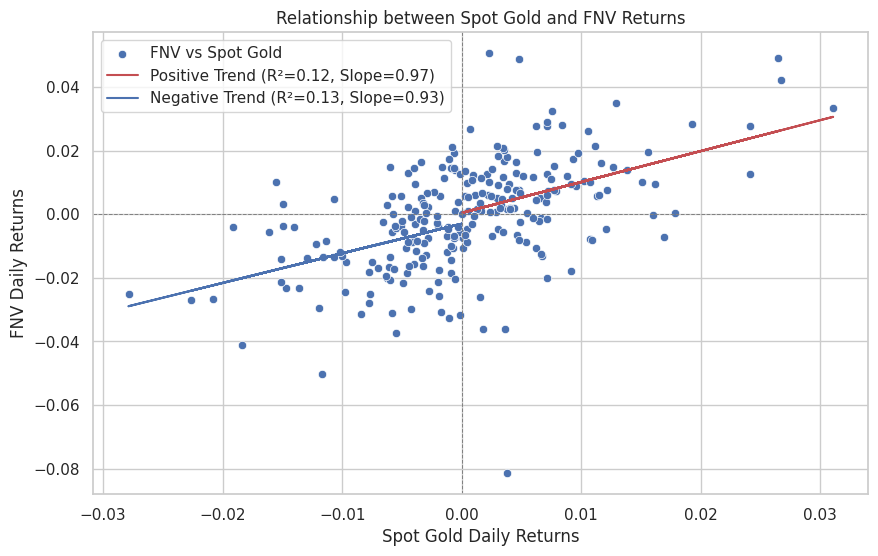

FNV vs Spot Gold (Positive Changes):
  R-squared: 0.12
  Slope: 0.97

FNV vs Spot Gold (Negative Changes):
  R-squared: 0.13
  Slope: 0.93

FNV Slope Ratio (Positive/Negative): 1.05



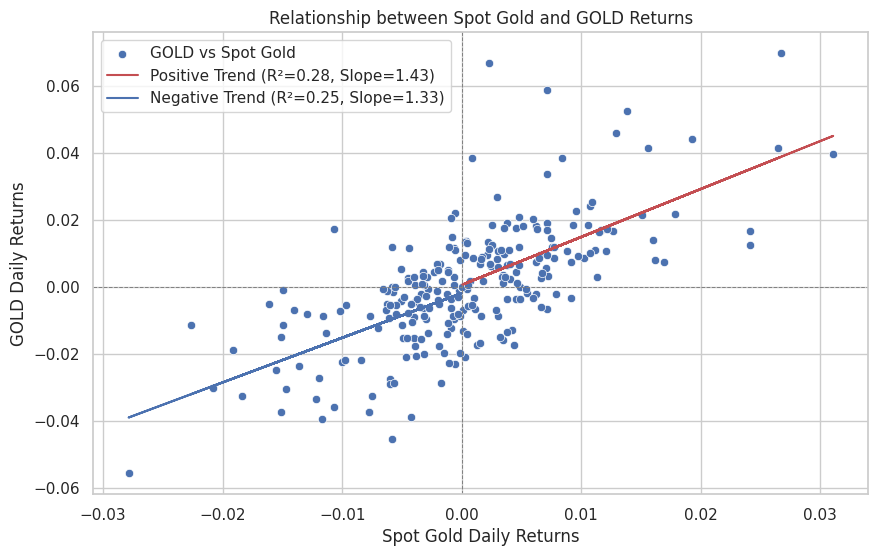

GOLD vs Spot Gold (Positive Changes):
  R-squared: 0.28
  Slope: 1.43

GOLD vs Spot Gold (Negative Changes):
  R-squared: 0.25
  Slope: 1.33

GOLD Slope Ratio (Positive/Negative): 1.07



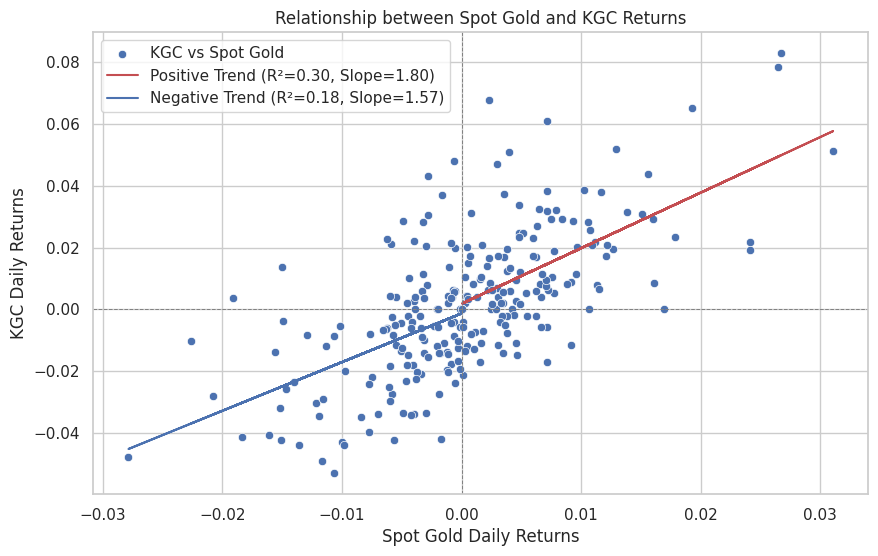

KGC vs Spot Gold (Positive Changes):
  R-squared: 0.30
  Slope: 1.80

KGC vs Spot Gold (Negative Changes):
  R-squared: 0.18
  Slope: 1.57

KGC Slope Ratio (Positive/Negative): 1.14



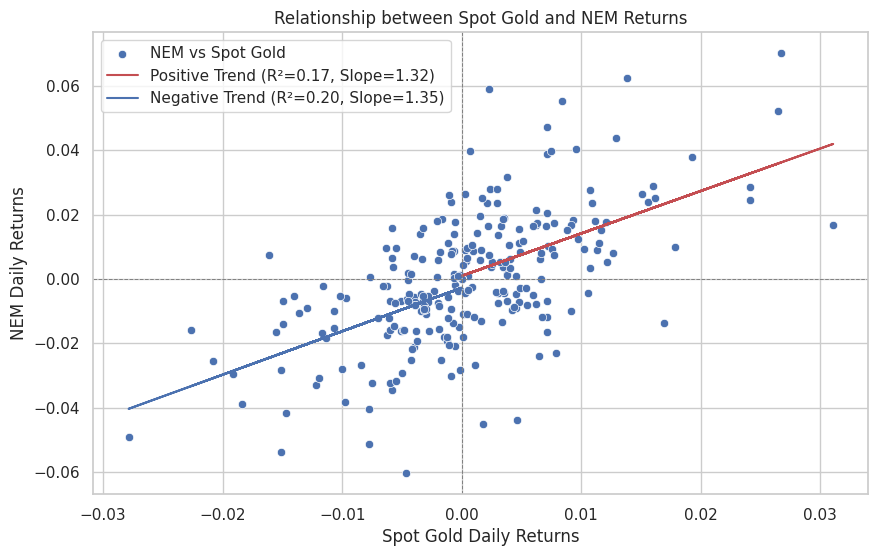

NEM vs Spot Gold (Positive Changes):
  R-squared: 0.17
  Slope: 1.32

NEM vs Spot Gold (Negative Changes):
  R-squared: 0.20
  Slope: 1.35

NEM Slope Ratio (Positive/Negative): 0.98



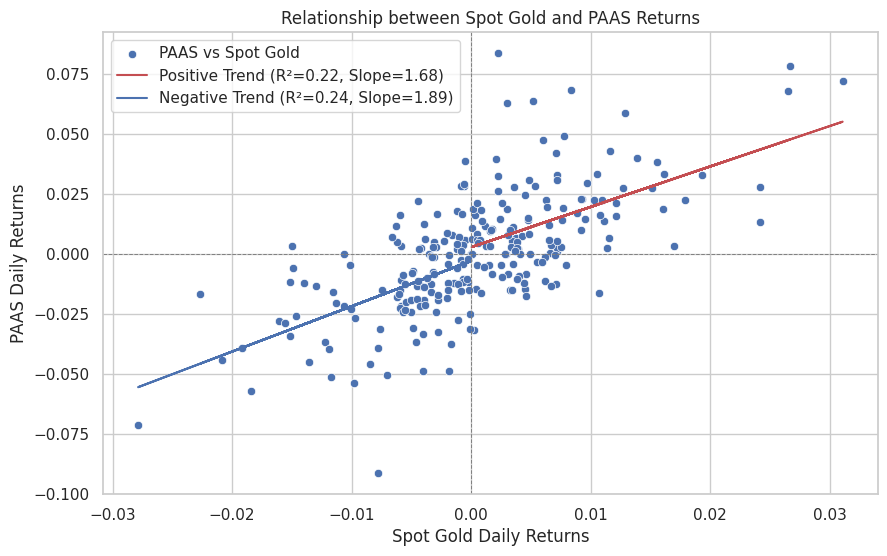

PAAS vs Spot Gold (Positive Changes):
  R-squared: 0.22
  Slope: 1.68

PAAS vs Spot Gold (Negative Changes):
  R-squared: 0.24
  Slope: 1.89

PAAS Slope Ratio (Positive/Negative): 0.89



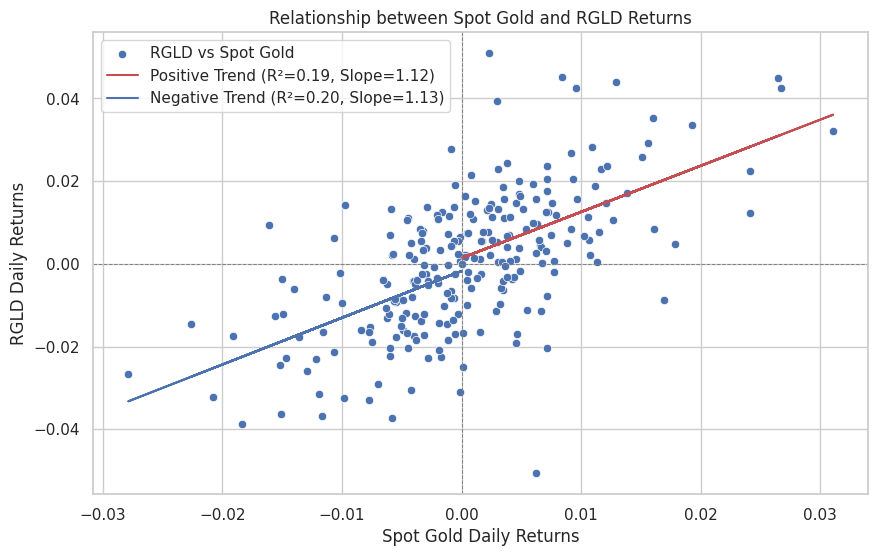

RGLD vs Spot Gold (Positive Changes):
  R-squared: 0.19
  Slope: 1.12

RGLD vs Spot Gold (Negative Changes):
  R-squared: 0.20
  Slope: 1.13

RGLD Slope Ratio (Positive/Negative): 0.99



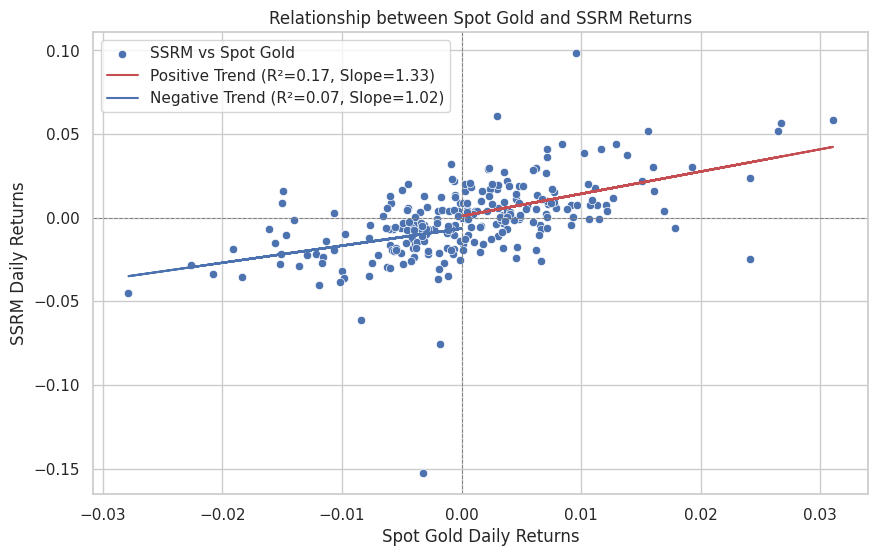

SSRM vs Spot Gold (Positive Changes):
  R-squared: 0.17
  Slope: 1.33

SSRM vs Spot Gold (Negative Changes):
  R-squared: 0.07
  Slope: 1.02

SSRM Slope Ratio (Positive/Negative): 1.30



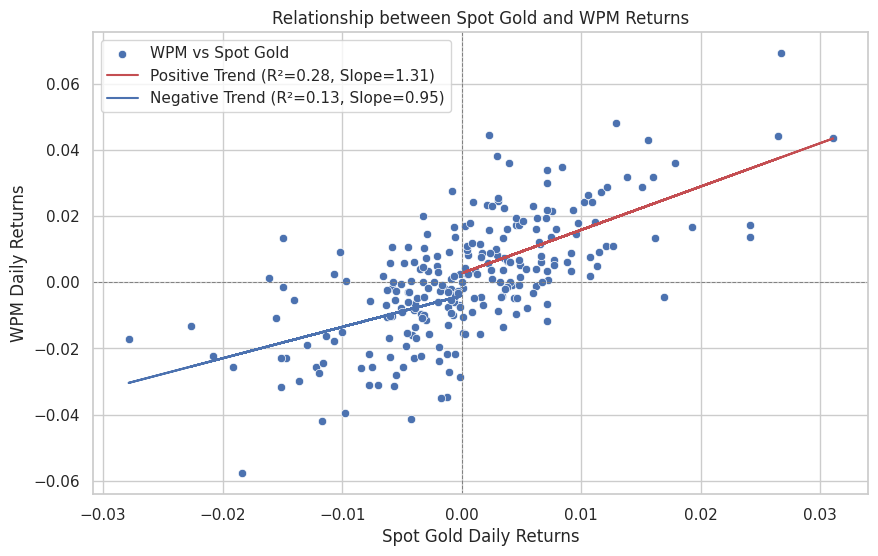

WPM vs Spot Gold (Positive Changes):
  R-squared: 0.28
  Slope: 1.31

WPM vs Spot Gold (Negative Changes):
  R-squared: 0.13
  Slope: 0.95

WPM Slope Ratio (Positive/Negative): 1.39

AEM Slope Ratio (Positive/Negative): 1.09
AGI Slope Ratio (Positive/Negative): 1.07
BTO.TO Slope Ratio (Positive/Negative): 1.27
EDV.TO Slope Ratio (Positive/Negative): 1.22
ELD.TO Slope Ratio (Positive/Negative): 0.83
FNV Slope Ratio (Positive/Negative): 1.05
GOLD Slope Ratio (Positive/Negative): 1.07
KGC Slope Ratio (Positive/Negative): 1.14
NEM Slope Ratio (Positive/Negative): 0.98
PAAS Slope Ratio (Positive/Negative): 0.89
RGLD Slope Ratio (Positive/Negative): 0.99
SSRM Slope Ratio (Positive/Negative): 1.30
WPM Slope Ratio (Positive/Negative): 1.39


In [22]:
# Split the data
positive_changes = daily_returns[daily_returns["GC=F"] > 0]
negative_changes = daily_returns[daily_returns["GC=F"] <= 0]

from scipy.stats import linregress

# Function to perform piecewise linear regression and plot
def plot_piecewise_linear_regression(company):
    plt.figure(figsize=(10, 6))

    # Scatter plot
    sns.scatterplot(x=spot_gold_returns, y=daily_returns[company], label=f'{company} vs Spot Gold')

    # Linear regression for positive changes
    slope_pos, intercept_pos, r_value_pos, p_value_pos, std_err_pos = linregress(positive_changes["GC=F"], positive_changes[company])

    # Linear regression for negative changes
    slope_neg, intercept_neg, r_value_neg, p_value_neg, std_err_neg = linregress(negative_changes["GC=F"], negative_changes[company])

    # Plot regression lines
    plt.plot(positive_changes["GC=F"], intercept_pos + slope_pos * positive_changes["GC=F"], 'r', label=f'Positive Trend (R²={r_value_pos**2:.2f}, Slope={slope_pos:.2f})')
    plt.plot(negative_changes["GC=F"], intercept_neg + slope_neg * negative_changes["GC=F"], 'b', label=f'Negative Trend (R²={r_value_neg**2:.2f}, Slope={slope_neg:.2f})')

    # Plot titles and labels
    plt.title(f'Relationship between Spot Gold and {company} Returns')
    plt.xlabel('Spot Gold Daily Returns')
    plt.ylabel(f'{company} Daily Returns')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.legend()

    # Show plot
    plt.show()

    # Print R-squared and slope for both parts
    print(f'{company} vs Spot Gold (Positive Changes):')
    print(f'  R-squared: {r_value_pos**2:.2f}')
    print(f'  Slope: {slope_pos:.2f}\n')

    print(f'{company} vs Spot Gold (Negative Changes):')
    print(f'  R-squared: {r_value_neg**2:.2f}')
    print(f'  Slope: {slope_neg:.2f}\n')

    # Calculate and print the slope ratio
    slope_ratio = slope_pos / slope_neg if slope_neg != 0 else float('inf')
    print(f'{company} Slope Ratio (Positive/Negative): {slope_ratio:.2f}\n')

    return slope_ratio

ratios = {}

for company in companies:
    ratios[company] = plot_piecewise_linear_regression(company)

for company, ratio in ratios.items():
    print(f'{company} Slope Ratio (Positive/Negative): {ratio:.2f}')

In [23]:
#sort ratios
sorted_ratios = {k: v for k, v in sorted(ratios.items(), key=lambda item: item[1])}
for company, ratio in sorted_ratios.items():
    print(f'{company} Slope Ratio (Positive/Negative): {ratio:.2f}')

ELD.TO Slope Ratio (Positive/Negative): 0.83
PAAS Slope Ratio (Positive/Negative): 0.89
NEM Slope Ratio (Positive/Negative): 0.98
RGLD Slope Ratio (Positive/Negative): 0.99
FNV Slope Ratio (Positive/Negative): 1.05
AGI Slope Ratio (Positive/Negative): 1.07
GOLD Slope Ratio (Positive/Negative): 1.07
AEM Slope Ratio (Positive/Negative): 1.09
KGC Slope Ratio (Positive/Negative): 1.14
EDV.TO Slope Ratio (Positive/Negative): 1.22
BTO.TO Slope Ratio (Positive/Negative): 1.27
SSRM Slope Ratio (Positive/Negative): 1.30
WPM Slope Ratio (Positive/Negative): 1.39


### Discussion

The analysis presented through the correlation matrix and scatter plots explores the relationship between the daily returns of various gold-related equities and the spot gold price. This investigation aims to identify potential market inefficiencies and relative valuations of these equities based on their sensitivity to changes in gold prices.

#### Limitations

One of the primary limitations observed in this analysis is the relatively low R-squared values in some of the scatter plots. The R-squared value indicates the proportion of variance in the dependent variable (equity returns) that can be explained by the independent variable (spot gold returns). Low R-squared values suggest that a significant portion of the variance in equity returns is not explained by changes in the gold price, pointing to the influence of other factors such as company-specific news, broader market trends, and macroeconomic conditions.

Another limitation is the use of data spanning only one year. Over this period, the per-share valuations of the companies can change due to various factors such as earnings reports, management changes, and shifts in market sentiment. Thus, while the analysis provides insights into short-term relationships, it may not fully capture the long-term trends or intrinsic valuations of the companies.

#### Potential Improvements

To address these limitations, several enhancements could be considered:

1. **Polynomial Regression**: While linear regression provides a straightforward way to assess the relationship, it may not capture the complexity of the data. Polynomial regression could offer a better fit by accommodating non-linear relationships between the variables. By fitting a polynomial curve to the data, we might achieve higher R-squared values, indicating a better explanatory power of the model.

2. **Longer Time Frame**: Expanding the analysis to cover a longer time frame could provide more robust insights into long-term trends and valuations. This would help mitigate the impact of short-term fluctuations and offer a clearer picture of the relationship between gold prices and equity returns.

3. **Additional Metrics**: Incorporating other financial metrics, such as earnings, cash flow, and debt levels, could enhance the analysis. These factors often influence stock prices and their inclusion could improve the explanatory power of the model.

#### Results

The slope ratios presented below quantify the sensitivity of each equity's returns to positive and negative changes in the gold price. A slope ratio greater than 1 indicates that the equity's returns are more sensitive to positive changes in the gold price than to negative changes, suggesting a potential undervaluation by the market.

- **AEM Slope Ratio (Positive/Negative)**: 1.09
- **AGI Slope Ratio (Positive/Negative)**: 1.07
- **BTO.TO Slope Ratio (Positive/Negative)**: 1.27
- **EDV.TO Slope Ratio (Positive/Negative)**: 1.22
- **ELD.TO Slope Ratio (Positive/Negative)**: 0.83
- **FNV Slope Ratio (Positive/Negative)**: 1.05
- **GOLD Slope Ratio (Positive/Negative)**: 1.07
- **KGC Slope Ratio (Positive/Negative)**: 1.14
- **NEM Slope Ratio (Positive/Negative)**: 0.98
- **PAAS Slope Ratio (Positive/Negative)**: 0.89
- **RGLD Slope Ratio (Positive/Negative)**: 0.99
- **SSRM Slope Ratio (Positive/Negative)**: 1.30
- **WPM Slope Ratio (Positive/Negative)**: 1.39

These ratios, alongside the correlation and regression analysis, provide a nuanced understanding of how different gold-related equities respond to changes in the gold price. Despite the limitations, these findings can be indicative of long-term trends and offer valuable insights for investors looking to identify potentially undervalued stocks within the gold sector.